# Single-Cell RNAseq Analysis: Preprocessing and Cell Type Clustering

In this project you will acquire hands-on experience analysing real-world single-nucleus RNA sequencing (snRNA-seq) data. The goal of this introductory exercise is to get familiarity with Python syntax, data types and structures, and grow your practical skills in large-scale data manipulation and visualisation through an analysis of cell clustering. From an applied standpoint, you’ll be introduced to powerful Python packages commonly used in the analysis of single-cell gene expression data.

__Workflow__

This notebook will guide you through the basic analysis steps required to conduct cell-type clustering of snRNA-seq data. A step-by-step outline is provided below.

_Data reading and exploration_ 
This notebook starts from a preprocessed AnnData object containing raw expression counts for 38,917 genes across 7,140 cells derived from the kidney of a healthy male. Gene-level and cell(barcode)-level metadata are also stored in this object. The initial step is to locate, read, and explore the data. 

_Filtering of genes and barcodes_  
An essential processing step is the identification and filtering of zero- and lowly-expressed genes, which don’t add much to the transcriptomic heterogeneity of the cells, which we often aim to study.  Equally important is the detection of barcodes with outlier quality-control (QC) metrics, representing either poor-quality cells, empty droplets, or droplets with more than one cell/nucleus; followed by analytical decisions to exclude or retain such barcodes for downstream analysis.  

_Normalisation of gene expression data_  
In this step, raw read counts are adjusted for differences in sequencing depth across cells, enabling the comparison of expression levels between them. Counts are also transformed into a more interpretable scale with convenient statistical properties for downstream applications. Common methods include library size normalisation followed by log transformation.

_Dimensionality reduction_  
We perform Principal Component Analysis (PCA) on the data, which is a common first step to linearly reduce the dimensionality of normalised data.

_Cell clustering_  
Unsupervised cell clustering aims to group the data (cells) based on their transcriptomic similarities in a reduced space. This is done using algorithms such as K-means and Leiden.  Non-linear dimensionality reduction techniques such as UMAP (Uniform Manifold Approximation and Projection) or t-SNE (t-distributed Stochastic Neighbor Embedding) are used for visualising the resulting cell clusters and cell type marker expression.


__What you need__  
You are expected to have at least basic Python knowledge, specifically in data handling and visualisation, a basic understanding of molecular cell biology and genomics.

__What is not required__  
Despite the nature of the analysis, you do not need a background in single-cell/nucleus RNAseq to be able to perform this project, nor a deep understanding of the mathematical theory behind dimensionality reduction and clustering. 

__Instructions__  
Work through this notebook from top to bottom, and answer __Questions__ and perform __Tasks__ you see along the way.  You are expected to write and demonstrate your answers by adding cells of text or code, where appropriate. 

__Authors__  
Iris Diana Yu, EMBL-EBI  
Daianna Gonzalez Padilla, Wellcome Sanger Institute


## Table of contents  
1. [Background](#background)
2. [Reading data](#reading_data)
3. [Gene annotation](#gene_annotation)
4. [Filtering](#filtering)  
    4.1 [Filtering barcodes](#filtering_barcodes)  
    4.2 [Filtering genes](#filtering_genes)  
    4.3 [Doublet removal](#doublet_removal)  
5. [Normalisation](#normalisation)

## 1. Background

### Data

The data analysed in this notebook were generated in [Muto et al. (Nature Communications, 2021)](https://www.nature.com/articles/s41467-021-22368-w) and retrieved from the Single Cell Expression Atlas, accession [E-CURD-119](https://www.ebi.ac.uk/gxa/sc/experiments/E-CURD-119/results/cell-plots), [downloaded here](https://www.ebi.ac.uk/gxa/sc/experiments/E-CURD-119/downloads). In the study, the cellular diversity of the adult human kidney was thoroughly characterized through single-cell transcriptome and chromatin accessibility profiling, analysing kidney samples from five healthy adults.  


In this project, we will only analyse the single-cell transcriptomics data for one sample corresponding to a healthy 54-year old male known as `Healthy1`.  

We start with the partially filtered sampled data set contained in an AnnData `.h5ad` file.

### Setting up

In [1]:
import pandas as pd
import scanpy as sc
import seaborn as sns

# set plotting theme
sns.set_theme()

<a id="reading_data"></a>
## 2. Reading data

We start by reading the data using one of the read functions from `scanpy` ([documented here](https://scanpy.readthedocs.io/en/stable/api/reading.html)).

In [2]:
adata = sc.read("project_data.h5ad")
adata

AnnData object with n_obs × n_vars = 7140 × 38917
    obs: 'age', 'clinical_information', 'developmental_stage', 'disease', 'ethnic_group', 'individual', 'organism_part', 'organism', 'sex', 'authors_cell_type_-_ontology_labels', 'authors_cell_type', 'sex.1', 'age_ontology', 'clinical_information_ontology', 'developmental_stage_ontology', 'disease_ontology', 'ethnic_group_ontology', 'individual_ontology', 'organism_part_ontology', 'organism_ontology', 'sex_ontology', 'authors_cell_type_-_ontology_labels_ontology', 'authors_cell_type_ontology', 'sex_ontology.1', 'doublet_score', 'predicted_doublet'
    var: 'gene_symbols', 'chromosome', 'start', 'end', 'width', 'source', 'type', 'score', 'phase', 'gene_version', 'gene_name', 'gene_source', 'gene_biotype', 'mito'

This AnnData object stores several pieces of information, including: 

- A matrix of counts, with samples as rows and genes as columns. This can be retrived with the `.X` accessor.
- Metadata about the barcodes (cells), which can be retrieved using the `.obs` accessor. 
- Metadata about the genes, which can be retrived using the `.var` accessor.

In the output above, the top line `AnnData object with n_obs × n_vars = 7140 × 38917` tells us the shape of the data set.  The `n_obs` is the number of observations in `.obs`--in this case, the sequencing barcodes, which we can more or less think of as equivalent to cells.  The `n_vars` is the number of variables in `.vars`, which in our case are genes. 

![Diagram of the AnnData object type. [Source](https://scanpy.readthedocs.io/en/stable/usage-principles.html)](https://falexwolf.de/img/scanpy/anndata.svg)


### Question
What data types are `adata.X`, `adata.obs`, and `adata.var` respectively?

<a id="gene_annotation"></a>
## 3. Gene Annotation

Let's inspect `adata.var`, where the gene metadata are stored.

In [3]:
adata.var

,gene_symbols,chromosome,start,end,width,source,type,score,phase,gene_version,gene_name,gene_source,gene_biotype,mito
ENSG00000001461,NIPAL3,1,24415802.0,24472976.0,57175.0,ensembl_havana,gene,NaN,NaN,17.0,NIPAL3,ensembl_havana,protein_coding,False
ENSG00000010072,SPRTN,1,231337104.0,231355023.0,17920.0,ensembl_havana,gene,NaN,NaN,16.0,SPRTN,ensembl_havana,protein_coding,False
ENSG00000008118,CAMK1G,1,209583714.0,209613939.0,30226.0,ensembl_havana,gene,NaN,NaN,10.0,CAMK1G,ensembl_havana,protein_coding,False
ENSG00000009780,FAM76A,1,27725961.0,27763116.0,37156.0,ensembl_havana,gene,NaN,NaN,16.0,FAM76A,ensembl_havana,protein_coding,False
ENSG00000048707,VPS13D,1,12230030.0,12512047.0,282018.0,ensembl_havana,gene,NaN,NaN,15.0,VPS13D,ensembl_havana,protein_coding,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000286009,NaN,Y,12661309.0,12663478.0,2170.0,havana,gene,NaN,NaN,2.0,NaN,havana,lncRNA,False
ENSG00000286247,NaN,Y,20725331.0,20734526.0,9196.0,havana,gene,NaN,NaN,1.0,NaN,havana,lncRNA,False
ENSG00000286201,NaN,Y,16599730.0,16644539.0,44810.0,havana,gene,NaN,NaN,1.0,NaN,havana,lncRNA,False
ENSG00000286130,NaN,Y,2828192.0,2840851.0,12660.0,havana,gene,NaN,NaN,1.0,NaN,havana,lncRNA,False


Above we see that `adata.var` is indexed with the human ENSEMBL gene IDs.  The human gene IDs can be explored [here](https://www.ensembl.org/Homo_sapiens/Info/Index).  The common gene name equivalent of these gene IDs are stored in `adata.var["gene_name"]`.

### Questions
1. What kind of information do you think are stored in the `adata.var` columns, namely the "gene_symbols", "chromosome", and "mito" columns?
2. What values are stored in the `adata.var` column "mito"? How many unique values are there?
3. What values are stored in the `adata.var` column "chromomosome". How many unique values are there?
4. What is the relationship of values between `adata.var` columns "mito" and "chromosome"?
5. Upon inspecting the `adata.var` column "chromosome", do you notice anything unusual?

We would like to keep only genes in the autosomes (1 through 23), X, Y and MT chromosome (i.e., remove genes in unassembled scaffolds).  Below is how we perform it.

In [4]:
vars_to_keep = (
  adata.var["chromosome"]
  .isin([str(i) for i in range(1, 23)] + ["X", "Y", "MT"])
)
adata = adata[:, vars_to_keep].copy()
adata

AnnData object with n_obs × n_vars = 7140 × 38901
    obs: 'age', 'clinical_information', 'developmental_stage', 'disease', 'ethnic_group', 'individual', 'organism_part', 'organism', 'sex', 'authors_cell_type_-_ontology_labels', 'authors_cell_type', 'sex.1', 'age_ontology', 'clinical_information_ontology', 'developmental_stage_ontology', 'disease_ontology', 'ethnic_group_ontology', 'individual_ontology', 'organism_part_ontology', 'organism_ontology', 'sex_ontology', 'authors_cell_type_-_ontology_labels_ontology', 'authors_cell_type_ontology', 'sex_ontology.1', 'doublet_score', 'predicted_doublet'
    var: 'gene_symbols', 'chromosome', 'start', 'end', 'width', 'source', 'type', 'score', 'phase', 'gene_version', 'gene_name', 'gene_source', 'gene_biotype', 'mito'

Note the use of the `.copy()` method. This ensures that we make a new copy of the object (which we replace back into `adata`), rather than a "View" of the original object.

### Questions
1. Explain each line of code in the cell that modifies `adata` to retain genes mapping to valid chromosomes. 
2. How many genes do we now have in our data, after retaininig only genes in valid chromosomes?

<a id="filtering"></a>
## 4. Filtering

We start by doing some exploratory analysis of our count data, namely in terms of:  

- number of total counts per barcode  
- number of detected genes per barcode  
- fraction of counts in mitochondrial genes

We use the function `scanpy.pp.calculate_qc_metrics`.  You can read more about the function [in the scanpy documentation](https://scanpy.readthedocs.io/en/stable/generated/scanpy.pp.calculate_qc_metrics.html).

In [5]:
sc.pp.calculate_qc_metrics(
    adata, 
    qc_vars=["mito"], 
    inplace=True, 
    percent_top=[20], 
    log1p=True
)
adata

AnnData object with n_obs × n_vars = 7140 × 38901
    obs: 'age', 'clinical_information', 'developmental_stage', 'disease', 'ethnic_group', 'individual', 'organism_part', 'organism', 'sex', 'authors_cell_type_-_ontology_labels', 'authors_cell_type', 'sex.1', 'age_ontology', 'clinical_information_ontology', 'developmental_stage_ontology', 'disease_ontology', 'ethnic_group_ontology', 'individual_ontology', 'organism_part_ontology', 'organism_ontology', 'sex_ontology', 'authors_cell_type_-_ontology_labels_ontology', 'authors_cell_type_ontology', 'sex_ontology.1', 'doublet_score', 'predicted_doublet', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito'
    var: 'gene_symbols', 'chromosome', 'start', 'end', 'width', 'source', 'type', 'score', 'phase', 'gene_version', 'gene_name', 'gene_source', 'gene_biotype', 'mito', 'n_cells_by_counts', 'mean_counts', 'log1p_me

### Questions  
1. Explain each parameter that we supplied to `sc.pp.calculate_qc_metrics`.
2. The execution of the function added several metrics to our barcode/cell metadata, i.e. our `adata.obs`.  What are these new metrics?  Explain each.
3. Some metrics were also added to the gene metadata, `adata.var`.  What are these new metrics? Explain each.

<a id="filtering_barcodes"></a>
### 4.1 Filtering barcodes

Since `adata.obs` is a regular Pandas DataFrame, we can use standard plotting libraries to visualise some of the statistics that the previous function calculated for us.  

### Task  
Using Seaborn, generate the following:
1. A plot showing the distribution of total UMI counts per cell. Use 20 bins.
2. A plot showing the distribution of percent mitochondrial UMIs per cell. Use 20 bins.
3. A plot showing the relationship between the total UMI counts per cell and the number of genes with at least 1 count in a cell.  Color the data points based on the percent of mitochondrial UMIs per cell.  

### Question  
Based on each plot, what can you say about the data?

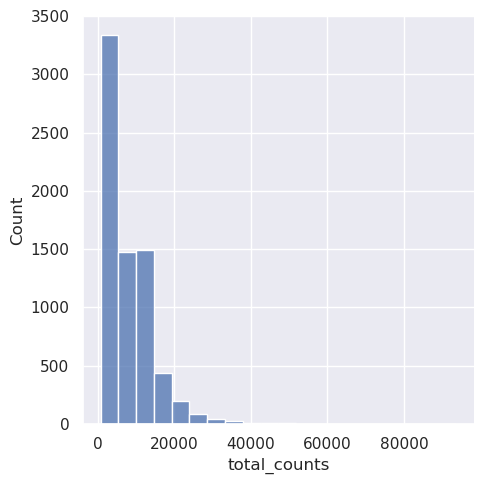

In [6]:
sns.displot(adata.obs, x="total_counts", bins=20)

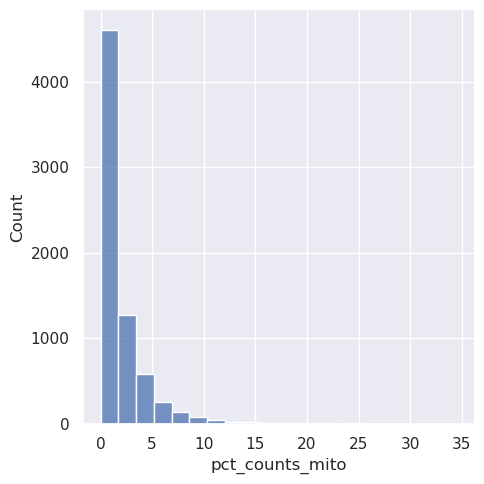

In [7]:
sns.displot(adata.obs, x="pct_counts_mito", bins=20)

<Axes: xlabel='total_counts', ylabel='n_genes_by_counts'>

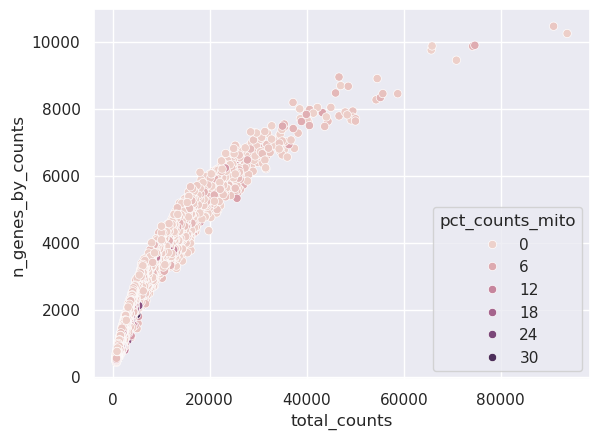

In [8]:
sns.scatterplot(adata.obs, x="total_counts", y="n_genes_by_counts", hue="pct_counts_mito")

Alternatively, we can use `scanpy`'s own plotting functions (histogram is not available, but we can do violin plots instead):  

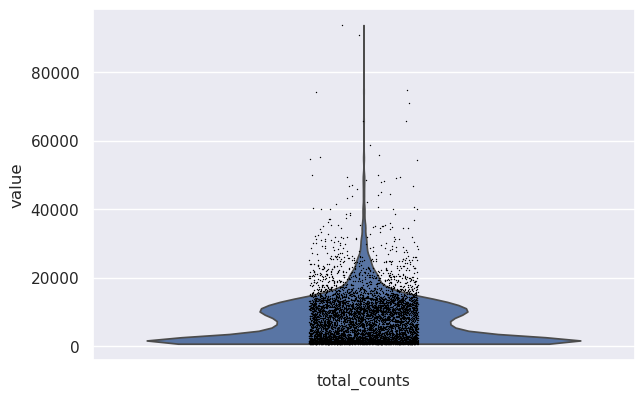

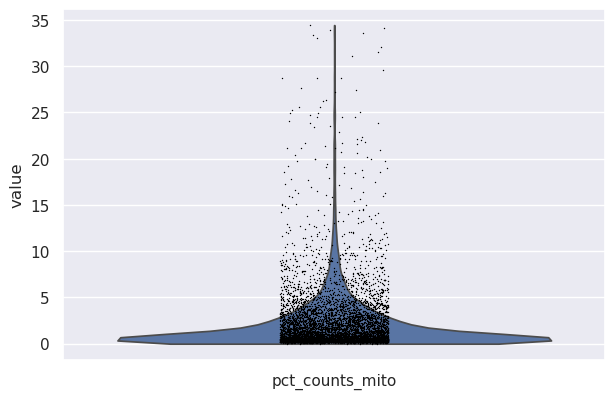

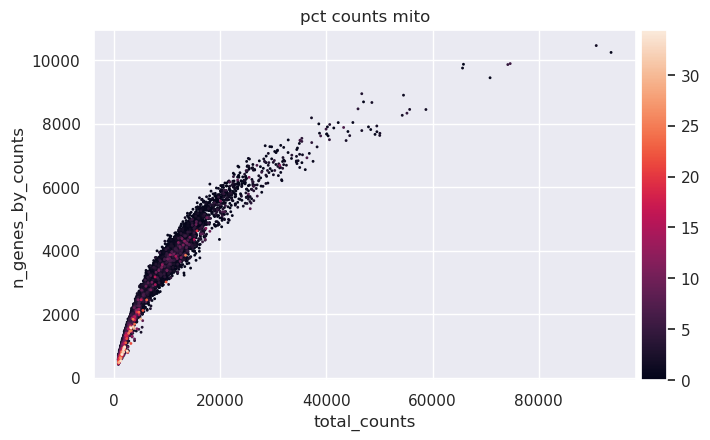

In [9]:
sc.pl.violin(adata, "total_counts")
sc.pl.violin(adata, "pct_counts_mito")
sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mito")

We can even do several violin plots at once: 

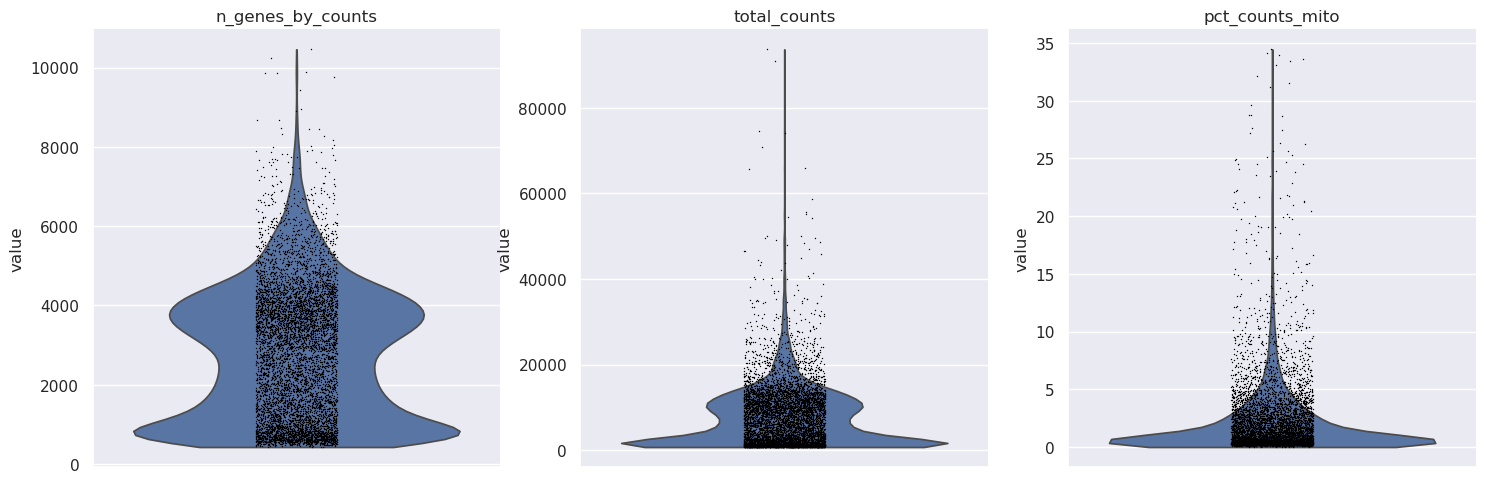

In [10]:
sc.pl.violin(
  adata,
  ["n_genes_by_counts", "total_counts", "pct_counts_mito"],
  multi_panel=True
)

We can filter our barcodes/cells based on hard thresholds set manually.  Alternatively, we can define a function that removes outliers based on the observed distribution.  For instance, we can use an `n` number of median absolute deviations (MAD) to determine outliers. More about MAD in [this Wikipedia entry](https://en.wikipedia.org/wiki/Median_absolute_deviation). Below, we create a MAD-based function that determines outlier observations in a given metric. It uses the `scipy.stats` function `median_abs_deviation`, with documentation [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.median_abs_deviation.html).

In [11]:
import numpy as np
from scipy.stats import median_abs_deviation

def is_outlier(adata, metric: str, nmads: int):
  M = adata.obs[metric]
  
  outlier = (M < np.median(M) - nmads * median_abs_deviation(M)) | (
      np.median(M) + nmads * median_abs_deviation(M) < M
  )
  return outlier

### Questions  
Explain the function `is_outlier`.  
1. What are the inputs and what is their role in the function?
2. What kind of data is passed onto the variable `outlier`?
3. Explain the expression used to derive `outlier`.

### Partial answer  
The function returns `True` or `False` depending on whether the value exceeds the specified value of median absolute deviation.

### Tasks  
1. Use the function `is_outlier` to create new barcode metadata columns indicating counts outliers.  Use `nmads = 5`.  Do this for each of the following:
    1. For raw counts outliers, use `counts_outlier` as the new metadata name. Determine outliers using `log1p_total_counts`.
    2. For gene counts outliers, use `genes_outlier` as the new metadata name.  Determine outliers using `log1p_n_genes_by_counts`.
    3. For top genes outliers, use `topgenes_outlier` as the new metadata name.  Determine outliers using `pct_counts_in_top_20_genes`.  

2. Create a histogram for each of the chosen metrics above, and color the histogram by based on outliers.  Hint: `sns.displot(adata.obs, x="metric_col_name", hue="outlier_col_name", multiple="stack")`.  

Note that we choose to use the log-transformed counts, as its distribution should be less skewed and therefore more suitable for MAD-based filtering.  

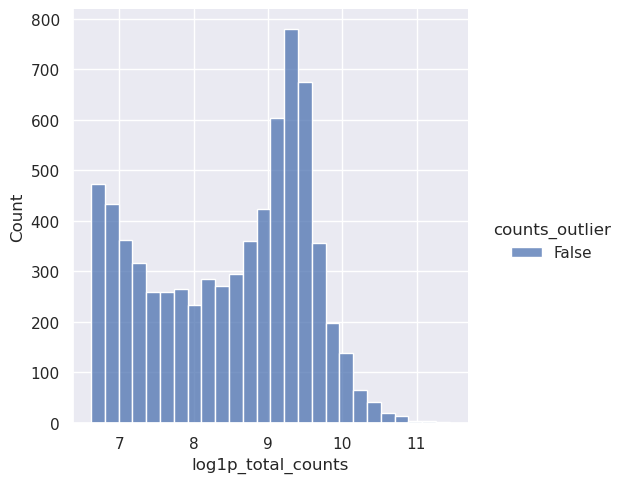

In [12]:
# create barcode metadata column indicating counts outliers
adata.obs["counts_outlier"] = is_outlier(adata, "log1p_total_counts", 5)

# visualise
sns.displot(adata.obs, x="log1p_total_counts", hue="counts_outlier", multiple="stack")

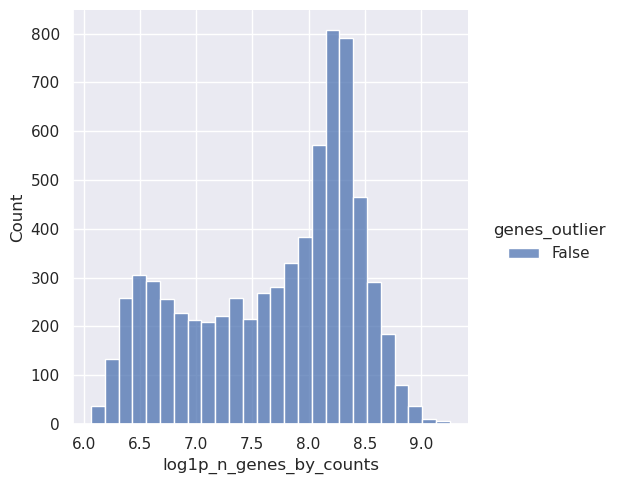

In [13]:
adata.obs["genes_outlier"] = is_outlier(adata, "log1p_n_genes_by_counts", 5)
sns.displot(adata.obs, x="log1p_n_genes_by_counts", hue="genes_outlier", multiple="stack")

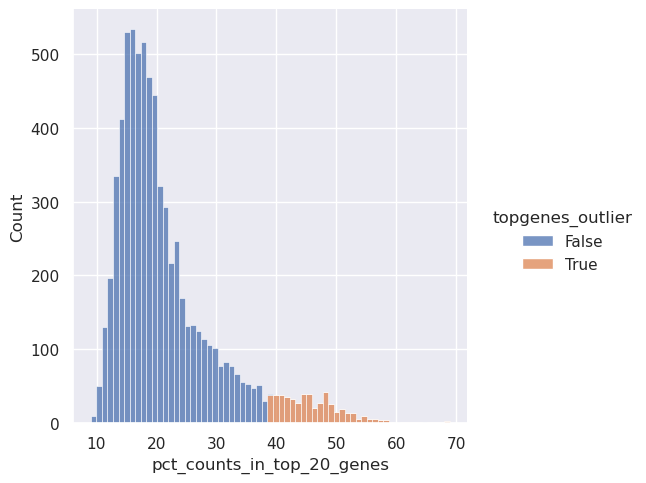

In [14]:
adata.obs["topgenes_outlier"] = is_outlier(adata, "pct_counts_in_top_20_genes", 5)
sns.displot(adata.obs, x="pct_counts_in_top_20_genes", hue="topgenes_outlier", multiple="stack")

We also check for outliers with regards to percentage of mitochondrial counts, where we use more strict filters: 

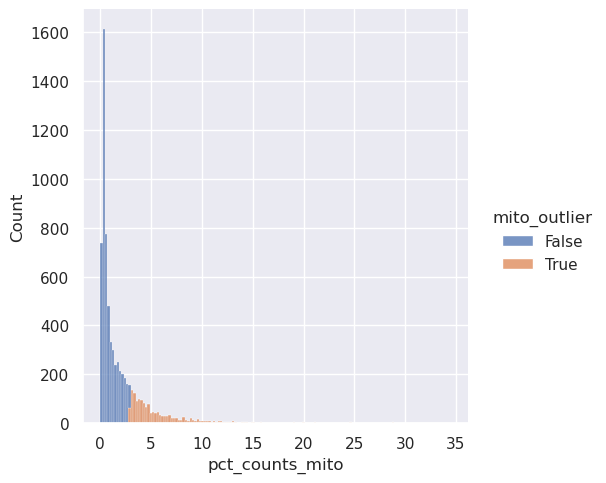

In [15]:
adata.obs["mito_outlier"] = is_outlier(adata, "pct_counts_mito", 3) | (adata.obs["pct_counts_mito"] > 8)
sns.displot(adata.obs, x="pct_counts_mito", hue="mito_outlier", multiple="stack")

### Question  
1. How many are considered outliers per metric filter?
2. Discuss the data based on what each of the four plots show.

Let us now create a variable which is the union of the conditions we set for our filters.  That is, if a barcode is determined an outlier of _any_ of our filters, then we consider it to be an outlier. 

In [16]:
adata.obs["outlier"] = adata.obs["genes_outlier"] | adata.obs["genes_outlier"] | adata.obs["topgenes_outlier"] | adata.obs["mito_outlier"]
adata.obs["outlier"].value_counts()

outlier
False    5495
True     1645
Name: count, dtype: int64

### Task  
Create the same scatterplot of counts vs detected genes you created earlier, but color the data points according which barcodes will be removed. 

<Axes: xlabel='total_counts', ylabel='n_genes_by_counts'>

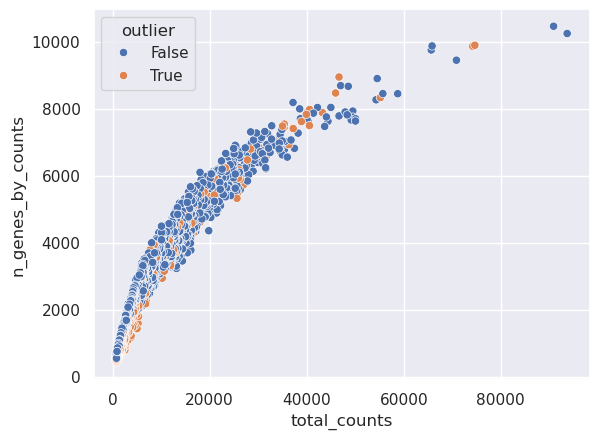

In [17]:
sns.scatterplot(adata.obs, 
                x = "total_counts", 
                y = "n_genes_by_counts",
                hue = "outlier")

We now remove all outliers from our data set.

In [18]:
adata = adata[~adata.obs["outlier"], :].copy()
adata

AnnData object with n_obs × n_vars = 5495 × 38901
    obs: 'age', 'clinical_information', 'developmental_stage', 'disease', 'ethnic_group', 'individual', 'organism_part', 'organism', 'sex', 'authors_cell_type_-_ontology_labels', 'authors_cell_type', 'sex.1', 'age_ontology', 'clinical_information_ontology', 'developmental_stage_ontology', 'disease_ontology', 'ethnic_group_ontology', 'individual_ontology', 'organism_part_ontology', 'organism_ontology', 'sex_ontology', 'authors_cell_type_-_ontology_labels_ontology', 'authors_cell_type_ontology', 'sex_ontology.1', 'doublet_score', 'predicted_doublet', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'counts_outlier', 'genes_outlier', 'topgenes_outlier', 'mito_outlier', 'outlier'
    var: 'gene_symbols', 'chromosome', 'start', 'end', 'width', 'source', 'type', 'score', 'phase', 'gene_version', 'gene_name', 'g

### Question  

The barcodes we are left with after this filtering we will now consider to be cells. How many cells are we left with?

<a id="filtering_genes"></a>
### 4.2 Filtering Genes

In the same way that we explored several metrics for barcodes, we can also explore them for genes. However, as we will see, downstream analysis can focus on variable genes and will mostly ignore genes for which there is very little data. Therefore, we don't perform as strict filtering on genes as we do on barcodes.    

Still, it is useful to remove undetected genes, i.e. those with zero total counts:

### Task  
Count how many genes have zero counts.  Hint: You may use the function `pd.DataFrame.eq()` function, [documentation here](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.eq.html).

In [19]:
# count of genes with zero counts
adata.var["total_counts"].eq(0).value_counts()

total_counts
False    38039
True       862
Name: count, dtype: int64

There is an out-of-the box method in `scanpy` to filter genes--`sc.pp.filter_genes()`.  The document is [here](https://scanpy.readthedocs.io/en/stable/generated/scanpy.pp.filter_genes.html).  We do the filtering as below.

In [20]:
sc.pp.filter_genes(adata, min_counts=0)

### Task  
Check number how many genes are left after removing zero-count genes.adata.n_vars

In [21]:
adata.n_vars

38901

<a id="doublet_removal"></a>
### 4.3 Doublet removal

In this special barcode filtering step, we remove droplet barcodes that may contain more than one cell or nucleus. This is an important step because, unremoved, these droplets known as "doublets" can be misclassified and thus confound downstream analysis.

### Question  
The `adata.obs` column `predicted_doublet` stores information on which cells are predicted doublets.  How many are predicted doublets and how many are not? 

In [22]:
adata.obs["predicted_doublet"].value_counts()

predicted_doublet
False    5495
Name: count, dtype: int64

At the moment, our count matrix has the following shape.

In [23]:
adata.shape

(5495, 38901)

Below is how we would filter out predicted doublets.

In [ ]:
# adata = adata[~adata.obs["predicted_doublet"], :].copy()

<a id="normalisation"></a>
## 4. Normalisation

There are several normalisation methods available for single-cell RNA-seq data. In this exercise, we will use shifted logarithm method.  This methods scales the counts by a cell-specific size factor (based on the total counts in that cell) followed by taking its logarithm. Despite being a relatively simple method, it has been shown to perform well in downstream analysis such as dimensionality reduction and clustering.  

We will use the `layers` component of the AnnData object, which can be used to store different versions of our count matrix.  This is a good way to keep several versions of our data in place, especially as we explore different methods of normalisation.

In [24]:
from scipy.sparse import csr_matrix

# keep a copy of the raw counts in the object as a backup
adata.layers["counts"] = adata.X.copy()

# create new layer for log-normalised counts
adata.layers["logcounts"] = adata.X.copy()
sc.pp.normalize_total(adata, layer="logcounts", target_sum=10000)
sc.pp.log1p(adata, layer="logcounts")

/opt/conda/lib/python3.10/site-packages/scanpy/experimental/pp/_normalization.py:52: UserWarning: `normalize_pearson_residuals()` expects raw count data, but non-integers were found.
  warn(
/opt/conda/lib/python3.10/site-packages/scanpy/experimental/pp/_normalization.py:68: RuntimeWarning: invalid value encountered in divide
  residuals = diff / np.sqrt(mu + mu**2 / theta)


### Question  
1. For normalisation, what does each line of the code do?  Refer to the documentations of the functions.
2. In what way did `adata` change after we performed normalisation?
3. What type of was is the new layer that was introduced?

### Task  
Visualise the normalised data.

In [25]:
adata

AnnData object with n_obs × n_vars = 5495 × 38901
    obs: 'age', 'clinical_information', 'developmental_stage', 'disease', 'ethnic_group', 'individual', 'organism_part', 'organism', 'sex', 'authors_cell_type_-_ontology_labels', 'authors_cell_type', 'sex.1', 'age_ontology', 'clinical_information_ontology', 'developmental_stage_ontology', 'disease_ontology', 'ethnic_group_ontology', 'individual_ontology', 'organism_part_ontology', 'organism_ontology', 'sex_ontology', 'authors_cell_type_-_ontology_labels_ontology', 'authors_cell_type_ontology', 'sex_ontology.1', 'doublet_score', 'predicted_doublet', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'counts_outlier', 'genes_outlier', 'topgenes_outlier', 'mito_outlier', 'outlier'
    var: 'gene_symbols', 'chromosome', 'start', 'end', 'width', 'source', 'type', 'score', 'phase', 'gene_version', 'gene_name', 'g

In [32]:
type(adata.layers["logcounts"])

scipy.sparse._csr.csr_matrix

We can visualise the distributions and correlations of the normalised data as a pair plot:

<Axes: xlabel='log_normalised_counts', ylabel='raw_counts'>

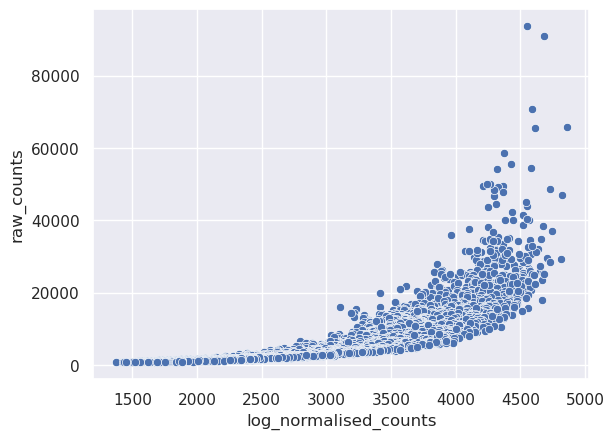

In [37]:
# note: np.nansum() only works in regular matrix, so we coerce from the sparse matrix format
sns.scatterplot(
  pd.DataFrame({"raw_counts": np.nansum(adata.layers["counts"].toarray(), 1),
              "log_normalised_counts": np.nansum(adata.layers["logcounts"].toarray(), 1)}), 
              x="log_normalised_counts", y="raw_counts"
)

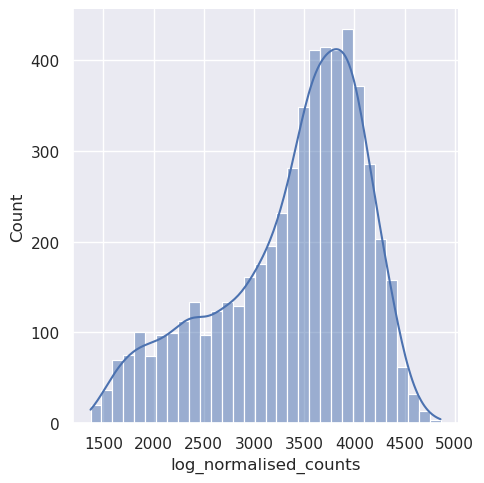

In [39]:
sns.displot(
  pd.DataFrame({"raw_counts": np.nansum(adata.layers["counts"].toarray(), 1),
              "log_normalised_counts": np.nansum(adata.layers["logcounts"].toarray(), 1)}), 
              x="log_normalised_counts", kde=True)

We now save our processed data.

In [40]:
adata.write(f"project_data_processed.h5ad")